<a href="https://colab.research.google.com/github/kapitalistka/DataSienceEducation/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. Загрузка данных

In [1]:
#!pip install kaggle
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pd.options.display.float_format = "{:,.2f}".format

In [3]:
def update_kaggle_token():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

update_kaggle_token()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [4]:
def download_kaggle_data():
  %cd /
  %cd /content
  !mkdir -p kaggle/HW3/
  %cd kaggle/HW3
  !kaggle competitions download -c sberbank-russian-housing-market
  %cd /content

download_kaggle_data();

/
/content
/content/kaggle/HW3
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
data_dictionary.txt: Skipping, found more recently modified local copy (use --force to force download)
macro.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
/content


In [5]:
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
file_zip_train = "kaggle/HW3/train.csv.zip"
file_train = "train.csv"

file_zip_test = "kaggle/HW3/test.csv.zip"
file_test = "test.csv"

In [7]:
raw_train_data = pd.read_csv(ZipFile(file_zip_train).open(file_train))
raw_test_data = pd.read_csv(ZipFile(file_zip_test).open(file_test))

## 1. Подготовка и  анализ данных

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

### Общая информация о наборе данных

In [9]:
df = raw_train_data
print("Shape:   " , df.shape)
print( '\nОбщая информация о  наборе данных:')
print(df.info())

Shape:    (30471, 292)

Общая информация о  наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB
None


In [303]:
df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,"30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00",...,"30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00"
mean,"15,237.92",54.21,34.40,7.67,12.56,1.25,"1,985.37",1.91,6.40,2.11,"17,657,051.42","84,056.43",0.22,0.12,"5,140.03","3,271.27",4.07,"5,354.27","8,324.97",4.71,0.11,"1,190.74",1.32,0.14,6.64,2.90,0.29,4.20,8.25,"146,306.15","67,207.79","79,098.66","11,178.81","5,723.85","5,455.01","53,667.91","27,253.59","26,414.41","19,209.71","5,811.62",...,765.90,"1,283.33","1,024.62",7.27,27.78,30.45,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.35,71.36,"1,401,057.39",30.13,"1,173,871.15",265.53,765.10,"1,278.28","1,021.69",17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99,"7,123,035.28"
std,"8,796.50",38.03,46.49,5.31,5.60,1.49,15.10,0.71,23.41,0.63,"20,649,607.99","57,871.29",0.18,0.12,"3,816.63","1,916.90",2.99,"3,989.64","3,790.06",3.45,0.33,766.65,1.49,0.44,6.57,3.29,1.51,4.74,23.54,"283,025.12","129,444.56","153,630.89","8,287.96","4,275.44","4,020.55","37,483.56","18,939.15","18,643.13","13,174.72","4,073.83",...,220.33,347.51,283.44,18.24,71.83,69.53,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.65,155.34,"2,303,052.49",23.92,"1,004,809.88",514.54,151.66,235.05,193.17,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89,"4,780,111.33"
min,1.00,0.00,0.00,0.00,0.00,0.00,"1,860.00",0.00,0.00,1.00,"2,081,627.76","2,546.00",0.00,0.00,175.00,0.00,0.00,168.00,"1,012.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,546.00","1,208.00","1,341.00",365.00,189.00,177.00,"1,633.00",863.00,771.00,548.00,156.00,...,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

### Проверим, сколько пропущенных значений в данных 

 51 колонка(и) содержат  пропущенные значения.


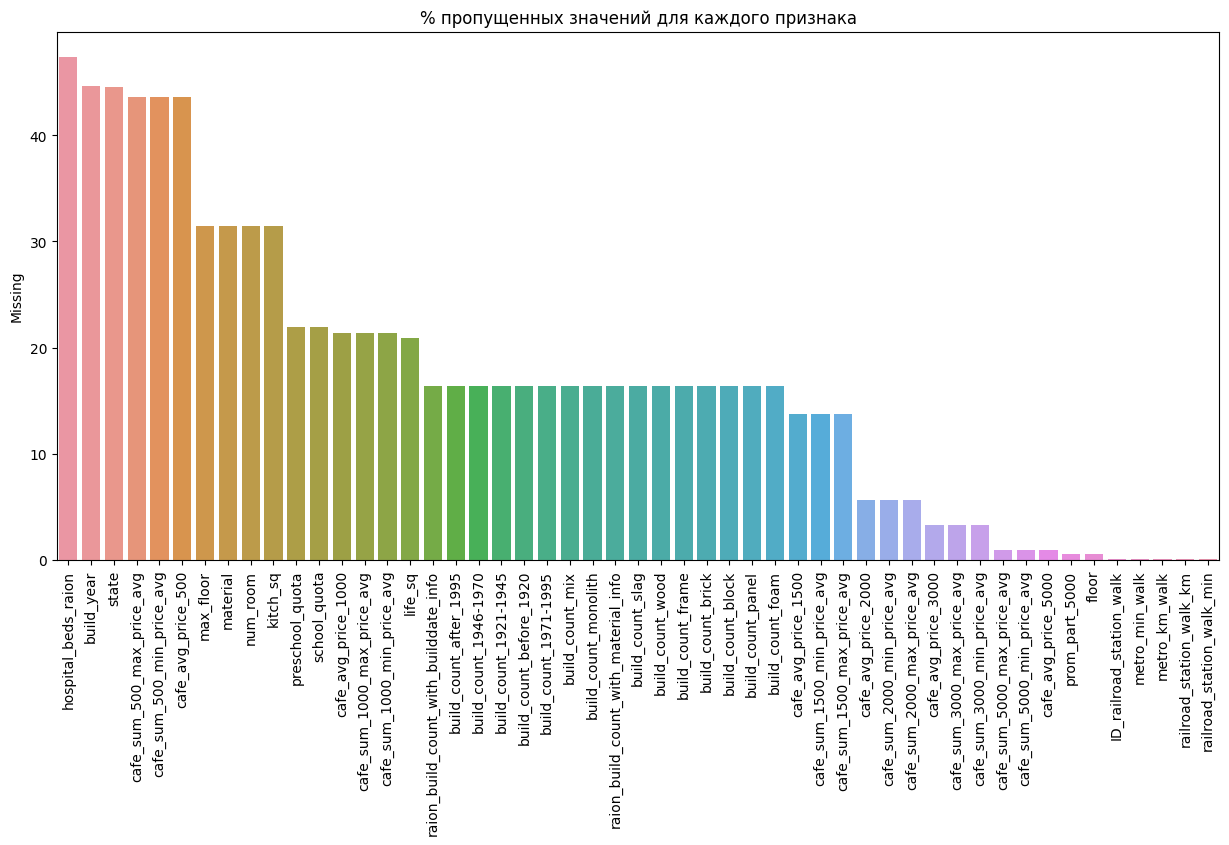

In [10]:
df_copy = df

missings_df = {}
for key in df_copy.columns:
    if df_copy[key].isnull().sum() > 0:
        missings_df[key] = (df_copy[key].isnull().sum()  /  len(df_copy[key]) ) * 100

missings_df = pd.DataFrame(missings_df,index=['Missing']).T.sort_values(by='Missing',ascending=False)

plt.figure(figsize=(15,7),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.Missing, x = missings_df.index, orient='v').set_title('% пропущенных значений для каждого признака')
print( f" {missings_df.shape[0]} колонка(и) содержат  пропущенные значения.")

### Отредактируем признаки для моделей обучения

В наборе данных мы видим признаки с вещественными числами (NUMERIC_COLS_WITH_MISSING_VALUES), категориальные признаики ,имеющие строковый  тип (CATEGORICAL_COLS ),  категориальные признаки с  пропущенными значениями STRING_COLS_WITH_MISSING_VALUES . 
Создадим метод для предобработки данных, который  будет преобразовывать набор, переданный ему в качестве аргумента.
Метод будет заменять пропущенные значения , преобразовывать строковые категориальные двнные в числовые, и применяет к маштабирование к числовым признакам.



In [11]:

NUMERIC_COLS_WITH_MISSING_VALUES = ['0_6_all', 'cafe_avg_price_1500', 'build_count_slag', 'green_part_1000', 'cafe_count_1000', 'mosque_count_1500', 
           'railroad_station_avto_min', 'market_shop_km', 'build_count_foam', 'sport_count_1000', 'material', 'leisure_count_5000', 'cafe_count_3000_price_1000', 
           'mosque_count_5000', 'big_church_count_500', 'preschool_education_centers_raion', 'green_zone_part', '16_29_male', 'school_km', 'hospice_morgue_km', 
           'power_transmission_line_km', 'mosque_count_1000', 'university_top_20_raion', 'ID_bus_terminal', 'cafe_count_2000', 'school_education_centers_top_20_raion', 
           'raion_build_count_with_builddate_info', '7_14_male', 'prom_part_5000', 'cafe_sum_5000_max_price_avg', 'exhibition_km', 'big_road1_km', 
           'cafe_count_3000_na_price', 'big_church_count_3000', 'cafe_count_1500_price_high', 'metro_km_avto', 'young_female', 'cafe_count_500_price_4000', 
           'cafe_sum_1500_min_price_avg', 'area_m', 'prom_part_2000', 'green_part_3000', 'mosque_count_500', 'green_part_1500', 'cafe_count_3000_price_high', 
           'life_sq', 'sadovoe_km', 'church_count_3000', 'build_count_brick', 'sport_count_500', 'office_count_1500', 'school_education_centers_raion', 
           'cafe_count_5000_price_4000', 'trc_sqm_1500', 'workplaces_km', '0_17_all', '0_6_male', 'office_raion', 'ID_railroad_station_walk', 'cafe_count_1500', 
           'cafe_avg_price_5000', 'market_count_500', 'water_km', 'cafe_count_5000', 'industrial_km', 'cafe_count_2000_price_4000', 'cafe_count_1500_price_4000', 
           'market_count_2000', 'cafe_count_500_price_2500', 'cafe_avg_price_1000', 'metro_km_walk', 'church_count_500', 'healthcare_centers_raion', 
           'shopping_centers_km', 'cafe_count_3000_price_500', 'trc_count_1000', 'cafe_sum_2000_min_price_avg', 'cafe_count_500_price_1500', 'market_count_5000', 
           'kindergarten_km', 'cafe_count_500_price_high', 'big_road2_km', 'ID_railroad_station_avto', 'male_f', 'culture_objects_top_25_raion', 'office_count_2000', 
           'office_count_1000', 'build_count_panel', 'public_transport_station_min_walk', 'cafe_sum_1000_max_price_avg', 'cafe_count_1000_price_1500', '7_14_female',
            'build_count_frame', 'trc_count_500', '0_13_female', 'leisure_count_1500', 'cafe_count_3000_price_2500', 'water_treatment_km', 'green_zone_km', 
            'cafe_count_2000_price_high', 'work_male', 'full_all', 'cafe_sum_500_min_price_avg', 'trc_sqm_500', 'big_church_count_2000', 'trc_sqm_3000', 
            '0_17_female', '16_29_all', 'trc_sqm_5000', 'build_count_wood', 'cafe_count_1500_price_1000', 'bus_terminal_avto_km', 'build_count_1971-1995', 
            '16_29_female', 'oil_chemistry_km', 'park_km', 'office_sqm_1000', 'cafe_count_1000_na_price', 'cafe_sum_3000_max_price_avg', 'cafe_count_5000_price_1500',
             'big_church_count_1000', 'green_part_5000', 'work_female', 'public_transport_station_km', 'ID_metro', 'build_year', 'cafe_count_2000_price_1500', 
             'cafe_count_1000_price_500', 'office_sqm_500', 'green_part_2000', 'cafe_avg_price_2000', 'radiation_km', 'leisure_count_2000', 'cafe_count_500_price_1000', 
             'museum_km', '0_6_female', 'church_count_2000', 'cafe_count_5000_price_1000', 'cemetery_km', 'cafe_sum_3000_min_price_avg', 'cafe_count_500', 
             'hospital_beds_raion', 'railroad_km', 'sport_count_1500', 'cafe_count_3000_price_4000', '0_17_male', 'railroad_station_walk_min', 
             'cafe_sum_500_max_price_avg', 'big_church_count_5000', 'ts_km', 'railroad_station_avto_km', 'raion_popul', 'trc_count_3000', 'sport_objects_raion', 
             'cafe_count_1500_na_price', 'cafe_sum_2000_max_price_avg', 'swim_pool_km', 'cafe_count_2000_price_2500', 'big_market_km', 'cafe_sum_5000_min_price_avg', 
             'cafe_count_5000_price_2500', 'full_sq', 'build_count_monolith', 'prom_part_500', 'nuclear_reactor_km', 'additional_education_raion', 'leisure_count_1000', 
             'cafe_count_2000_na_price', 'bulvar_ring_km', 'cafe_count_1500_price_500', 'state', 'mosque_km', 'cafe_count_5000_price_high', 'sport_count_3000',
              'market_count_1500', 'incineration_km', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_3000', 'cafe_avg_price_500', 'build_count_after_1995', 
              'stadium_km', 'sport_count_5000', '0_13_all', 'theater_km', 'railroad_station_walk_km', 'public_healthcare_km', 'trc_sqm_2000', 'big_church_km', 
              'zd_vokzaly_avto_km', 'office_sqm_3000', 'mkad_km', 'build_count_before_1920', 'raion_build_count_with_material_info', 'preschool_quota', '7_14_all',
               'metro_min_avto', 'office_km', 'prom_part_1500', 'university_km', 'children_preschool', 'trc_count_5000', 'church_count_1000', 'fitness_km', 
               'trc_sqm_1000', 'office_sqm_2000', 'prom_part_3000', 'kitch_sq', 'shopping_centers_raion', 'cafe_count_1500_price_2500', 'cafe_count_2000_price_1000', 
               'cafe_count_500_price_500', 'school_quota', 'cafe_sum_1000_min_price_avg', 'office_count_3000', 'young_all', 'ID_big_road2', 'church_synagogue_km', 
               'trc_count_1500', 'indust_part', 'market_count_1000', 'office_count_5000', 'preschool_km', 'kremlin_km', 'young_male', 'office_count_500',
                'leisure_count_500', 'ekder_female', 'big_church_count_1500', 'cafe_count_1000_price_1000', 'office_sqm_5000', 'ID_railroad_terminal', 'ttk_km', 
                'thermal_power_plant_km', 'basketball_km', 'cafe_count_1000_price_4000', '0_13_male', 'max_floor', 'detention_facility_km', 'build_count_1946-1970', 
                'ice_rink_km', 'cafe_count_1000_price_high', 'prom_part_1000', 'mosque_count_3000', 'ID_big_road1', 'female_f', 'metro_min_walk',
                 'cafe_count_3000_price_1500', 'cafe_count_5000_price_500', 'cafe_count_3000', 'cafe_count_1500_price_1500', 'church_count_5000', 
                 'additional_education_km', 'trc_count_2000', 'work_all', 'cafe_count_500_na_price', 'church_count_1500', 'ekder_male', 'cafe_count_1000_price_2500', 
                 'ekder_all', 'leisure_count_3000', 'green_part_500', 'build_count_block', 'build_count_mix', 'children_school', 'office_sqm_1500', 'floor', 
                 'cafe_count_2000_price_500', 'cafe_count_5000_na_price', 'price_doc', 'catering_km', 'build_count_1921-1945', 'sport_count_2000', 'mosque_count_2000',
                  'num_room', 'market_count_3000']
                

STRING_COLS_WITH_MISSING_VALUES = ['nuclear_reactor_raion', 'product_type', 'radiation_raion', 'incineration_raion', 'railroad_terminal_raion',
                                   'big_road1_1line', 'water_1line', 'thermal_power_plant_raion', 'oil_chemistry_raion', 'big_market_raion', 
                                   'detention_facility_raion', 'ecology', 'railroad_1line', 'sub_area', 'timestamp', 'culture_objects_top_25']  

CATEGORICAL_COLS = ['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 
                    'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 
                    'big_road1_1line', 'railroad_1line', 'ecology']  

COLS_FOR_DROP = ['id', 'timestamp']  

NUMERIC_COLS_TO_SCALE = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m', 'raion_popul', 
                         'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school',
                         'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 
                         'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 
                         'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 
                         'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', 
                         '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', 
                         '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000', 'price_doc']




In [12]:
def process_data(data):

  for col in NUMERIC_COLS_WITH_MISSING_VALUES:
    if col in data:
      imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
      data[col] = imputer.fit_transform(data[col].values.reshape(-1,1))[:,0]


  for col in STRING_COLS_WITH_MISSING_VALUES:
    if col in data:
      imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
      data[col] = imputer.fit_transform(data[col].values.reshape(-1,1))[:,0]

  ord_encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
  data[CATEGORICAL_COLS] = pd.DataFrame(ord_encoder .fit_transform(data[CATEGORICAL_COLS]), columns=CATEGORICAL_COLS)

  for col in CATEGORICAL_COLS:
    data[col] = data[col].apply(lambda x: int(x) if x == x else "")

  for col in COLS_FOR_DROP:
    data = data.drop(col, 1)

  for col in NUMERIC_COLS_TO_SCALE:
    if col in data:
      data[col] = np.log1p(data[col])
    
  return data

## Разобьем данные на тестовый, обучающий и валидационный наборы

In [13]:
target = 'price_doc'
y = df[target]
X = df.drop(target, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train  = process_data(X_train)
X_val  = process_data(X_val)
X_test = process_data(raw_test_data)

## Проанализируем целевую переменную и другие признаки

Построим график распределения целевой переменной: видим что целевая переменная смещена и данные на правой части оси сильно разрежены. Для оптимального построения модели( чтобы данные выбросы не влияли ) применим логорифмирование. (Именно поэтому в методе подготовки данных применено логарифмирование к числовым признакам)

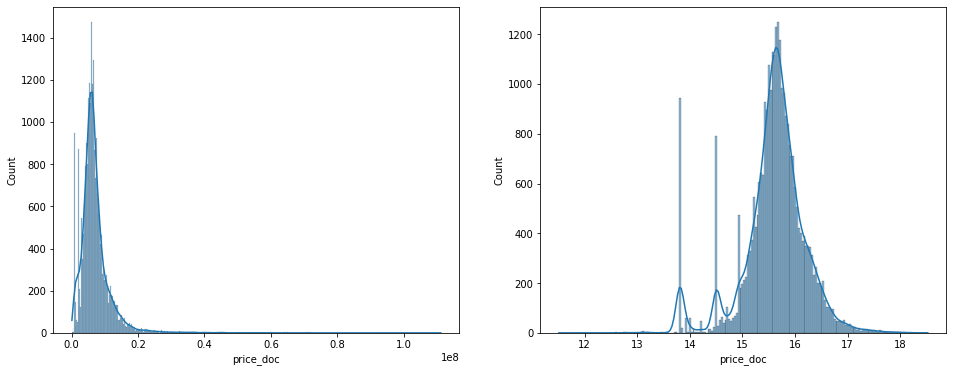

In [15]:
train = X
train[target] = y

fig = plt.figure(figsize = (16,6))
fig.add_subplot(1,2,1)
sns.histplot(train[target],kde = True,);

fig.add_subplot(1,2,2)
sns.histplot(np.log1p(train[target]),kde=True);

посмотрим на зависимость  целевой переменной  от признаковю Видим, что они слабо скореллированы. С существенным отрывом  Выделяются признаки num_room              и
full_sq . Можно выдвинуть гипотезу, что они внесут существенный вклад в результат модели

In [80]:
main_corr = train.corr()[target][abs(train.corr())[target]>0.2].head().sort_values(ascending=False)
main_corr


num_room               0.48
full_sq                0.34
sport_objects_raion    0.25
ttk_km                -0.27
sadovoe_km            -0.28
Name: price_doc, dtype: float64

Посмотрим на распределение первых 2х признаков:  в признаке 'full_sq' также видим выбросы. Попробуем прологарифмировать.


<Figure size 1152x432 with 0 Axes>

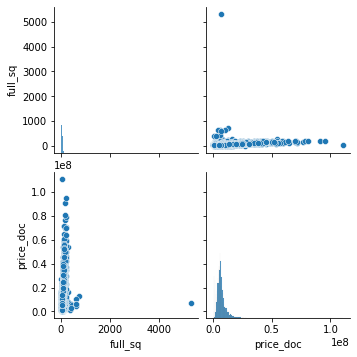

In [88]:
fig = plt.figure(figsize = (16,6))
sns.pairplot(train[['full_sq', target]])

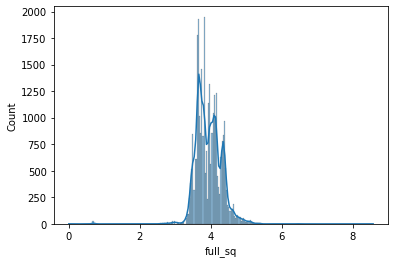

In [89]:
sns.histplot(np.log1p(train['full_sq']),kde = True,);


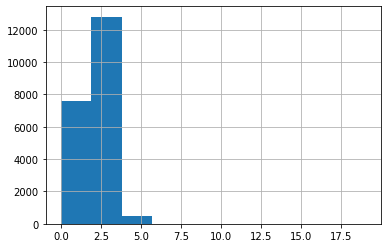

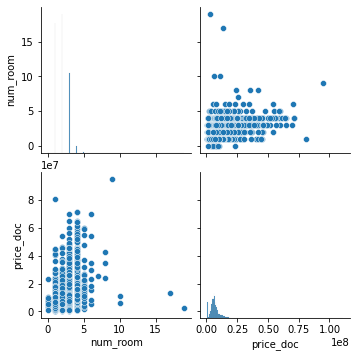

In [90]:
train['num_room'].hist()
sns.pairplot(train[['num_room', target]])

## Создание новых признаков

все мои попытки создать новые фичи, например последний или первый этаж или транспорто доступный район не привели к тому, чтобы новый признак появился в первых 30 элементах в feature-importances, аналогично с гипотезами, единственная, которая подтвердилась, что площадь (full_sq) существенно влияет на результат.

## 2. Построим модель

In [ ]:
#!pip install -q catboost shap

In [17]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

Выбран алгоритм CatBoost, тк он наиболее быстро проходит стадию обучения ( XGBoost на таком же наборе данных обучался порядка 2 х часов), также существенным критерием выбора было удобство работы данного алгоритма скатегориальными фичами - добавление их как аргумента существенно улучшило score модели.
При выборе гипер параметров сократила число итеракций до 500, тк при выбранной метрике алгоритм сходился ранее этого значения. Также пробовала "самописную" , найденную на просторах сети, eval -metric RMSLE, тк в данных соремнования указано что оенивание идет по этой метрике. Попытка была неудачной.

In [18]:
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=True,
              cat_features = CATEGORICAL_COLS)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    print(f"mean absolute error: {mean_squared_error(y_pred_val, y_val)}")
    print(f"mean absolute error: {mean_absolute_error(y_pred_val, y_val)}")
    print(f"r2 score: {r2_score(y_pred_val, y_val)}")
    print(f"mean squared log error: {mean_squared_log_error(y_pred_val, y_val)}")

    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [19]:
%%time
# Train Catboost and generate predictions
y_preds_test, cat_model = run_catboost(X_train, y_train, X_val, y_val,  X_test)

0:	learn: 4709285.8059662	test: 4503046.1744588	best: 4503046.1744588 (0)	total: 765ms	remaining: 6m 21s
50:	learn: 2592965.6679442	test: 2792608.8514830	best: 2792608.8514830 (50)	total: 35.6s	remaining: 5m 13s
100:	learn: 2226861.4678756	test: 2653898.7129787	best: 2653898.7129787 (100)	total: 1m 18s	remaining: 5m 8s
150:	learn: 2101990.8446187	test: 2614644.4852912	best: 2614644.4852912 (150)	total: 1m 52s	remaining: 4m 21s
200:	learn: 2018811.7572190	test: 2595518.5239188	best: 2595518.5239188 (200)	total: 2m 26s	remaining: 3m 38s
250:	learn: 1943596.2451062	test: 2578885.8402588	best: 2578885.8402588 (250)	total: 3m	remaining: 2m 59s
300:	learn: 1879970.1555855	test: 2570158.6834268	best: 2570158.6834268 (300)	total: 3m 33s	remaining: 2m 21s
350:	learn: 1813082.4985816	test: 2561320.4626701	best: 2561287.2771367 (348)	total: 4m 6s	remaining: 1m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 2558743.484
bestIteration = 372

Shrink model to first 373 iteration

##  Проанализируем важность признаков

In [25]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,15))
    #Plot Searborn bar chart
    fi_df = fi_df.head(50)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

На графике видим первые 50 признаков по важности вклада в результат.  Наиболеее  существенный вклад вносит признак full_sq. Тк мы видели , что при изучении корреляции  призкаов и целевой переменной первые несколько признаков были наиболее скореллированы, то гипотеза, что эти признаки больше вчего влияб на стоимость подтвердилась.

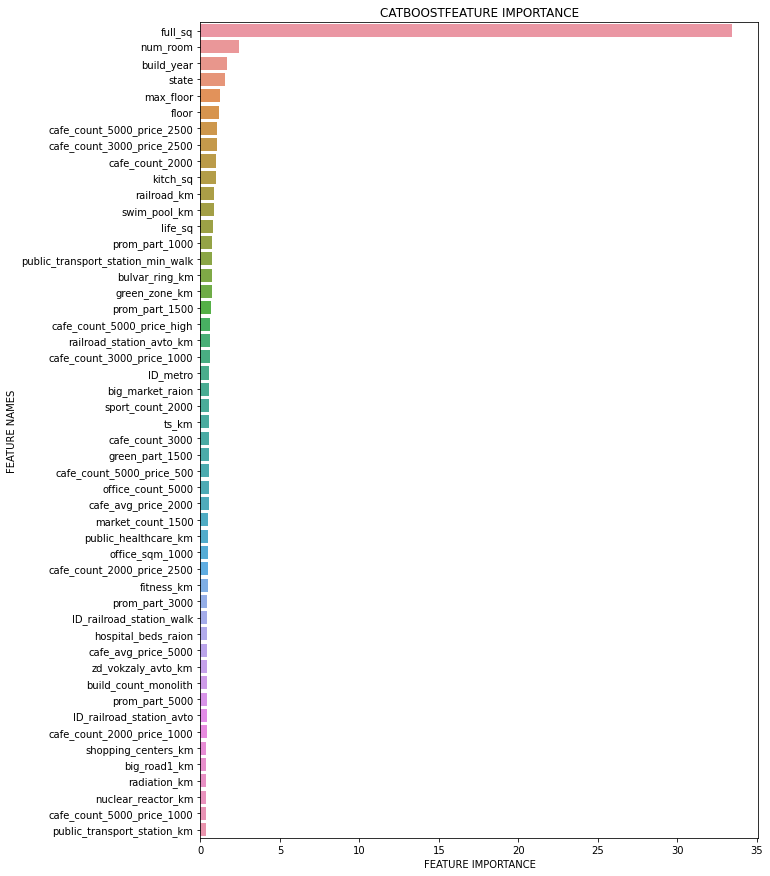

In [32]:
plot_feature_importance(cat_model.get_feature_importance(),X_train.columns,'CATBOOST')

### 3. Загрузка  тестовых значений

In [33]:
submission = pd.DataFrame(columns=['id'], data= raw_test_data)
submission[target] = y_preds_test
submission.head()

,id,price_doc
0,30474,"5,412,039.31"
1,30475,"8,112,135.28"
2,30476,"5,257,884.09"
3,30477,"5,619,375.05"
4,30478,"4,738,281.02"


In [34]:
submission.to_csv("submission.csv", index = False)


In [35]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "submission.csv" -m "the first attempt"

100% 180k/180k [00:07<00:00, 24.5kB/s]
Successfully submitted to Sberbank Russian Housing Market